# Oceny restauracji w aplikacji zomato

## Opis danych

Analizowane dane dotyczą ocen restauracji w Bengaluru w aplikacji zomato. Bengaluru to miasto w Indiach w którym na zomato jest zarejestrowane około 50 tys. restauracji.

Linki do danych i ich opisu: 
* https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants
* https://github.com/poddarhimanshu/Coursera_Capstone/blob/master/Final%20Project/Data%20Scraping/Documentation.pdf

## Cel analizy

Większość z ludzi w dzisiejszych czasach wybierając miejsce na obiad czy kolację sugeruje się opiniami w Internecie. Strona internetowa zomato zestawia opinie o restauracjach. Celem analizy jest predykcja oceny restauracji na podstawie zmiennych dostępnych w zbiorze. Pozwoli to odpowiedzieć na pytanie co wpływa na sukces restauracji i co możemy zrobić zakładając nową restaurację, aby zwiększyć szansę na jej pozytywny odbiór przez klientów.

## Przygotowanie danych

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost  import XGBRegressor

In [20]:
df = pd.read_csv("./data/zomato.csv")
df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [22]:
df.shape

(51717, 17)

In [23]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [24]:
df.dtypes

url                            object
address                        object
name                           object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)                object
listed_in(city)                object
dtype: object

Zmienna `dish_liked` zostaje wykorzystana do stworzenia zmiennej binarnej `any_dish_liked`, która zawiera informację o tym czy użytkownicy mają ulubione dania w tej restauracji. 

In [25]:
df['any_dish_liked'] = ~df.dish_liked.isna()

In [26]:
# usuniecie niepotrzebnych column
df = df.drop(['url', 'phone', 'reviews_list', 'menu_item', 'dish_liked', 'address', 'name'], axis=1)

In [27]:
df = df.dropna()
df = df[(df.rate != 'NEW') & (df.rate != '-')]

### Cel
Predykcja oceny restauracji.

## Preprocessing

Na początku dokonam operacji przygotowujących zbiór danych:

* zmiana typów danych,
* oczyszczenie danych tekstowych,
* usunięcie niepotrzebnych zmiennych.

In [32]:
df.rate = df.rate.apply(lambda x: x.replace("/5", ""))
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(lambda x: x.replace(",", ""))
df = df.astype({'rate': 'float32', 'approx_cost(for two people)': 'float32',})
df.online_order = (df.online_order == 'Yes')
df.book_table = (df.book_table == 'Yes')
df = df.drop(['location', 'cuisines'], axis=1) 
df.dtypes

online_order                      bool
book_table                        bool
rate                           float32
votes                            int64
rest_type                       object
approx_cost(for two people)    float32
listed_in(type)                 object
listed_in(city)                 object
any_dish_liked                    bool
dtype: object

Text(0.5, 1.0, 'Rozkład zmiennej objaśnianej `rate`.')

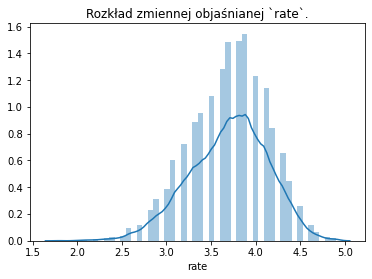

In [72]:
sns.distplot(df.rate, hist=True, kde=True).set_title("Rozkład zmiennej objaśnianej `rate`.")

In [35]:
le_type = LabelEncoder()
df['listed_in(type)'] = le_type.fit_transform(df['listed_in(type)'])
le_city = LabelEncoder()
df['listed_in(city)'] = le_city.fit_transform(df['listed_in(city)'])
le_rest_type = LabelEncoder()
df['rest_type'] = le_rest_type.fit_transform(df['rest_type'])

## Model bazowy

### Random Forest

In [89]:
X = df.drop('rate', axis=1)
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [90]:
rf_base =  RandomForestRegressor()
rf_base.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
print("R2 train: {}".format(r2_score(y_train, rf_base.predict(X_train))))
print("R2 test: {}".format(r2_score(y_test, rf_base.predict(X_test))))

R2 train: 0.9673869968336996
R2 test: 0.8015669568913759


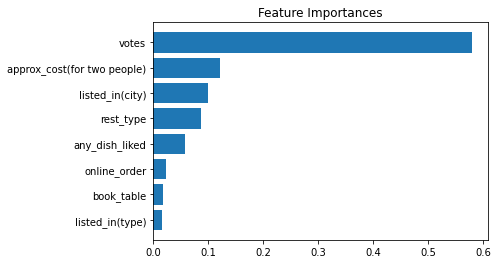

In [92]:
features = X_train.columns
importances = rf_base.feature_importances_
indices_imp = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices_imp)), importances[indices_imp])
plt.yticks(range(len(indices_imp)), [features[i] for i in indices_imp])
plt.show()

### xgboost

In [99]:
xgb_base =  XGBRegressor(learning_rate=0.01, n_estimators=500, max_depth=15)
xgb_base.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [100]:
print("R2 train: {}".format(r2_score(y_train, xgb_base.predict(X_train))))
print("R2 test: {}".format(r2_score(y_test, xgb_base.predict(X_test))))

R2 train: 0.8951213365122713
R2 test: 0.7770654503416804


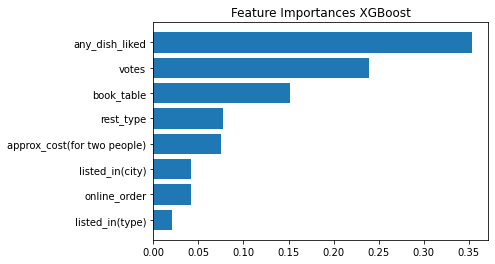

In [101]:
importances = xgb_base.feature_importances_
indices_imp = np.argsort(importances)

plt.title('Feature Importances XGBoost')
plt.barh(range(len(indices_imp)), importances[indices_imp])
plt.yticks(range(len(indices_imp)), [features[i] for i in indices_imp])
plt.show()

Wyniki bazowych modeli XGBoost i Random Forest są podobne, więc w dalszej analizie skupię się na lasach losowych.

## Optymalizacja hiperparametrow

Zarówno model Random Forest jak i XGBoost ma dużo hiperparametrów. Od ich wartości w dużej mierze zależy wynik modelu. Wyniki bazowych modeli pokazują, że modele te mają potencjał, ale występuje duże przuczenie. W związku z tym postanowiłam dokonać optymalizacji hiperparametrów z karą za przeuczenie. Optymalizacji dokonuje na walidacji krzyżowej 5-krotnej z karą za przeuczenie będącą różnicą pomiędzy $R^{2}$ na zbiorze treningowym i testowym.

$$ loss =  - \frac{1}{k} (\sum_{i=1}^{k} R^{2}_{test} - \sum_{i=1}^{k} | R^{2}_{test} - R^{2}_{train}|), $$
gdzie $ k=5.$ 

In [24]:
def hyperopt_train_test(params):
    kf = KFold(n_splits=5)
    r2_test = []
    r2_train = []
    for train_index, valid_index in kf.split(X_train):
        clf = RandomForestRegressor(**params)
        X_train_, y_train_ = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_valid, y_valid = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
        clf.fit(X_train_, y_train_)
        y_pred_train = clf.predict(X_train)
        y_pred_valid = clf.predict(X_valid)
        r2_train.append(r2_score(y_train_, clf.predict(X_train_)))
        r2_test.append(r2_score(y_valid, clf.predict(X_valid)))
    return np.mean(np.array(r2_test) - np.abs(np.array(r2_train) - np.array(r2_test)))

space_rf = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'max_features': hp.choice('max_features', range(1, 8)),
    'n_estimators': hp.choice('n_estimators', range(1, 1000)),
    'min_samples_split': hp.choice('min_samples_split', range(3, 15, 2))
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss': -r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space_rf, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:')
print(best)

pickle.dump(trials, open("./models/rf_trials.pkl", 'wb')) 

100%|██████████| 300/300 [6:08:47<00:00, 73.76s/trial, best loss: -0.5881227979904338]   
best:
{'max_depth': 15, 'max_features': 6, 'min_samples_split': 0, 'n_estimators': 347}


Wynik modelu po optymalizacji hiperparametrów 

In [67]:
best_hyparparameters = space_eval(space_rf, best)
best_hyparparameters

{'max_depth': 16,
 'max_features': 7,
 'min_samples_split': 3,
 'n_estimators': 348}

In [68]:
rf =  RandomForestRegressor(
    max_depth=best_hyparparameters['max_depth'], 
    max_features=best_hyparparameters['max_features'], 
    min_samples_split=best_hyparparameters['min_samples_split'], 
    n_estimators=best_hyparparameters['n_estimators'])
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=348, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
print("R2 train: {}".format(r2_score(y_train, rf.predict(X_train))))
print("R2 test: {}".format(r2_score(y_test, rf.predict(X_test))))

R2 train: 0.863578183878579
R2 test: 0.7530544721655512


## Ostateczny model

Model po optymalizacji hiperparametrów z karą za przeuczenie mniej się przeuczył niż poprzedni, ale cały czas występuje problem z przeuczeniem. Dodatkowo wynik pierwszego modelu jest lepszy na zbiorze testowym niż tego po optymalizacji hiperparametrów. W związku z tym jako ostateczny model wybieram `rf_base`. 

Okazuje się, że duży wpływ na ocenę restauracji na zomato ma liczba głosów, średnia cena za 2 osoby, położenie i typ restauracji.